# ECE113 Lab 1: Software Defined Radio - Part II

### Originally written by Miki Lustig for EE123 at UC Berkeley.
Updated by Josh Sanz, Spring 2020, Updated by Kambiz Shoarinejad for ECE113 at UCLA, Spring 2021

Before you start, you must make sure that the rtl-sdr drivers and its python support are installed. If you have not done so, then please follow the instructions provided here: 

https://inst.eecs.berkeley.edu/~ee123/sp18/rtl_sdr_install.html

https://ccle.ucla.edu/mod/page/view.php?id=3696944

### About the lab:

In this lab, we will look at the power spectrum of the NOAA radio signal and introduce settings of the SDR along the way. We will also look at the spectrum of a sample FM broadcast signal.



## About the SDR

The rtl-sdr usb dongles enables you to obtain samples from the electromagnetic spectrum around you. In very general terms, the dongle contains several components:

1. The antenna couples to received electromagnetic fields and tiny currents are produced in it. 
2. A tuner integrated circuit amplifies the signal, filters it, demodulates it to an intermediate frequency where it is filtered again. The dongles we distributed in class contain either the Refael Micro 820T (Black dongles) tuner or the Elonics E4000  (white dongles). 
3. All dongles are equipped with the realtek RTL2832U (hence rtl-sdr). Although the chip is capable of doing many things (like decoding TV in Europe), we use only its analog to digital converters and its USB interface.  The RTL2832U samples the signal that is coming from the tuner and spits out samples to the computer through the USB interface. 

The SDR returns samples at a desired rate up to 2.4MS/s (sometimes 3.5MS/s) of a part of the spectrum around a desired center frequency. For example, setting a center frequency $f_0 = 88.5\cdot 10^6$ and a sampling rate of $Fs=2\cdot 10^6$ will result in a complex valued sequence $x[n]$ whose DTFT corresponds to the physical frequency range of $87.5\cdot 10^6 < f < 89.5\cdot 10^6$. In other words, the digital frequency $\omega=0$ of $X(e^{j\omega})$, the DTFT of $x[n]$, will correspond to the physical frequency $88.5$MHz. The digital frequency $\omega=\pi$ will correspond to $89.5$MHz and $\omega=-\pi$ will correspond to $87.5$MHz.

Q) Why is the sequence $x[n]$ complex valued ??? 

A) Consider the case when there is a transmitter which outputs a pure frequency at 89MHz. We choose a center frequency of 88.5MHz and sampling rate of 2MHz. The spectrum of $x[n]$ will not be symmetric, and has to be complex valued! The received signal would be $x[n] = e^{i2\pi500000/2000000n} = e^{i\pi/2n}$ which will have a single frequency at $\omega=\pi/2$ --> corresponding to 89MHz. 



To learn about what you can do with SDR's, I  recommend you watch this youtube video. Most (not all) the stuff shown there can be done using rtl-sdr. At minute 5:00 you will see an example of ADS-B, which you will partly implement in this lab. (You will need internet connection to watch the video-- so it might not show up if you are connected to the raspberryPi via managed or ad-hoc)

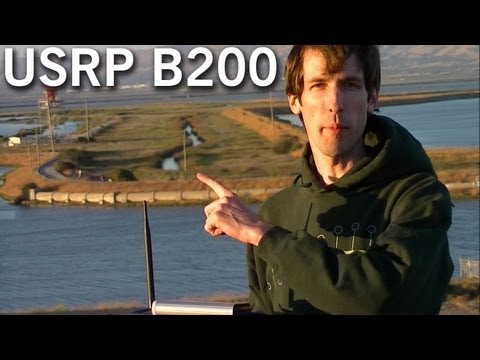

In [1]:
from IPython.display import YouTubeVideo
# A video on what you can do with Software defined radio. The B200 is a high-end SDR which is capable to much more than the rtl-sdr. 
# however, most of the stuff shown in the video could be done with the rtl-sdr as well. 
YouTubeVideo('cygDXeZaiOM')

In [2]:

# Import functions and libraries
import numpy as np, matplotlib.pyplot as plt
from numpy import *
from numpy.fft import *
from matplotlib.pyplot import *
#from rtlsdr import RtlSdr

import numpy.fft as fft

%matplotlib inline

## Task I: Capture data and compute the spectrum
Let's look at a simple example of acquring data and looking at its spectrum. NOAA weather radio is transmitted from Los Angeles KWO37 transmitter at 162.55MHz It is a 5KHz frequency modeulated (FM) audio signal that voices a recording of the weather. Here's a map of the Los Angeles coverage:

https://www.weather.gov/nwr/sites?site=KWO37

If you live in other areas in the US, you can find the NOAA transmitter frequencies here:

https://www.weather.gov/nwr/station_listing

It is best if you are outside of the building when collecting samples. Let's collect 4 seconds worth of samples, sampled with a center frequency of 162.5MHz and a sampling rate of 960KHz.

To Instantiate the sdr with the following parameters, which create the rtlsdr object, set the center frequency and the sampling rate

    sdr = RtlSdr()
    sdr.set_sample_rate(960000)      # sampling rate
    sdr.set_center_freq(162500000)   # 162.5MhZ center frequency
    

In [3]:
# code here
fs = 960000.
fc = 162500000.

It is also useful to set the gain appropriately. The default may be too high and may result in the signal saturatation. 

To see what are the valid gains, invoke: 

    print(sdr.valid_gains_db)

The result will depend on the type of SDR you have (there are a few variants).

In [ ]:
sdr = RtlSdr()
sdr.set_sample_rate(960000)      # sampling rate
sdr.set_center_freq(162500000)   # 162.5MhZ center frequency
print(sdr.valid_gains_db)

Pick a number that's one or two slots larger than the middle (around 37.2 I found to be working well) and set the gain using
    sdr.set_gain(gain)
    

In [ ]:
gain = 37.2
sdr.set_gain(gain)

The python interface to the SDR required that the number of samples be a multiple of 256. To read samples from the SDR, run the following command:

    N_samples = 960000*4 # 4 seconds
    y = sdr.read_samples(N_samples)   # get samples

If you are done with the device, you can clear it by:
    sdr.close()

In [ ]:
# Your code here
N_samples = 960000*4 # 4 seconds
y = sdr.read_samples(N_samples)   # get samples
sdr.close()

In case you still do not have an RTL-SDR dongle, or if you are having trouble with the SDR, uncomment the line below to load the pre-collected samples uploaded on CCLE:
``y = np.load('noaa_k.npy')``

In [4]:
#np.save('noaa.npy',y)

#In case you are having trouble with the SDR, uncomment the line below to load pre-collected samples 
y = np.load('noaa_k.npy')
print(y.shape)

(3840000,)


We will only use a small portion of it to process and look at the spectrum. Let’s crop the samples and analyze the spectrum of a portion of 16384 samples of it. We will use the function `fft` to compute the DFT and then `fftshift` to center the DFT around $\omega=0$. Remember, the signal you captured is complex valued, and hence has a two-sized spectrum. Intead of showing the spectrum in terms of $\omega$, plot it in terms of the physical frequencies. Use a Kaiser window with $\beta=6$. Use the function `plt.semilogy` to plot in log-scale. Make sure the axis is tight using `plt.axis` and that the aspect ratio of the figure is wide, so you can see the spectrum better



(162.0, 163.0, 0.01, 1000.0)

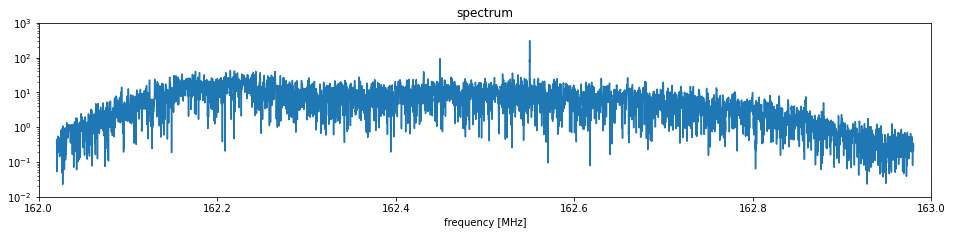

In [5]:
# Your Code here:
y_portion = y[0:16384]
N = len(y_portion)
Y_w = fft.fft(y_portion)
Y_w = fft.fftshift(Y_w)
Y_w = Y_w*np.kaiser(len(y_portion),6)
f = r_[-N/2:N/2]/N*fs + fc

#Plot
width, height = figaspect(0.2)
fig=plt.figure(figsize=(width,height))
p = plt.semilogy( f/1e6, abs(Y_w)), plt.xlabel('frequency [MHz]'); 
plt.title('spectrum');
plt.axis((162,163,10**(-2),10**(3)))

You should be able to see some energy in the spectrum around the right frequency. However, what you will notice immediately is that the spectrum is noisy. In addition there might be some spurious peaks and in the white dongles (E4000) there is also a large peak at the DC frequency. The peak at the DC frequency is due to constant bias in the ADC of the device. This translates to an impulse at $\omega = 0$. Spourius peaks come from local oscillator leak and also quantization errors. 

To reduce the noise and get a finer look at the spectrum, we will break our **entire sequence (not the cropped one)** into smaller sequences. We don't need such a good spectral resolution, so we will break it into chunks of 2048 samples, calculate their magnitude spectra, and average. This is also called the average power specrum.

* Reshape the sequence into a matrix with row size of 2048. Remember that the ordering of the matrix is 'C' style and hence row-first. 
* Multiply the rows by a kaiser window with $\beta=6$
* Compute fft and fftshift along the 2nd dimension. 
* Compute the absolute square of the result and average along the 1st dimension
* Plot the result

In [6]:
# Your code here:
x = np.array_split(y, 2048)
x = np.array(x)
       
Y_kaiser = fft.fft(x*np.kaiser(1875,6))
X = fft.fftshift(Y_kaiser)

#Compute mean
Pspect = mean(abs(X)*abs(X),axis=0);

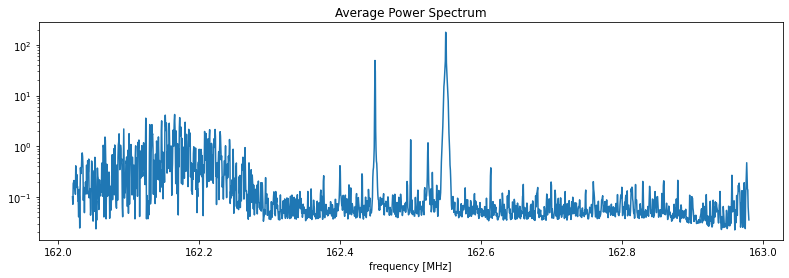

In [7]:
# Display:
N = len(Pspect)
f = r_[-N/2:N/2]/N*fs + fc

width, height = figaspect(0.3)
plt.figure(figsize=(width,height))
plt.semilogy(f/1e6, Pspect);
plt.xlabel('frequency [MHz]'); plt.title('Average Power Spectrum');


### Answer:
The spectral resolution is much better and the peak appeared very clear.
So yes, I can identify the NOAA weather station at about 162.55 MHz where the highest peak occurs.
However, there is also smaller peak at about 162.45 MHz, which is the leakage of the local oscilator.

This plot is called the average power spectrum. As you can see, the spectrum looks much nicer now. Can you identify the NOAA weather station? Only the wide spectrum peaks are real, BTW. The very narrow spiky peaks in the spectrum are probably due to leakage of the local oscilator, non-linearity in the receiver, and poor dynamic range of the ADC of the device. Still... for $25 it is not too bad!


* What is the spectral resolution in the plot?
* Repeat the the measurement and the average power spectrum for the center frequency 89.3MHz. Can you identify NPR's 89.3MHz station? (or use your own choice of FM frequency, depending on your location) 

Note: The rectangular bands you see around the main signal are HD radio signals. These are transmitted at the band edges and provide digital radio programming. Unfortunately HD radio in the USA uses proprietery protocol, and we can not easily decode it at this time. If you want to implement this yourself, you can visit [this](https://www.rtl-sdr.com/decoding-and-listening-to-hd-radio-nrsc-5-with-an-rtl-sdr/) link and follow the instructions there. 

In [ ]:
# Your code here:
fs = 960000.
fc = 162500000.

sdr = RtlSdr()
sdr.set_sample_rate(fs)
sdr.set_center_freq(fc)

gain = 37.2
sdr.set_gain(gain)

N_samples = 960000 * 4
y = sdr.read_samples(N_samples)

sdr.close()

In [8]:
#np.save('npr.npy',y)

#In case you are having trouble with the SDR, uncomment the line below to load the pre-collected samples
y = np.load('npr_k.npy')

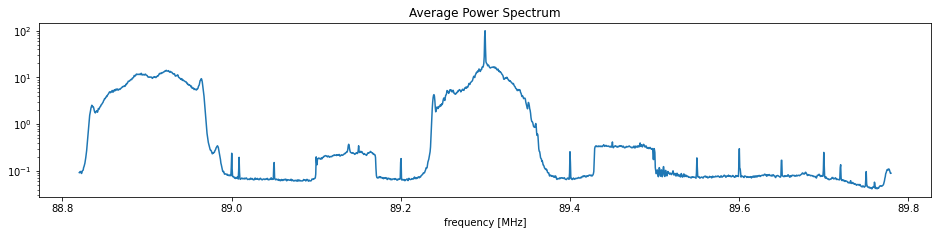

In [9]:
# Your Code here:
x = np.array_split(y, 2048)
x = np.array(x)
fc2 = 89300000
       
Y_kaiser = fft.fft(x*np.kaiser(1875,6))
X = fft.fftshift(Y_kaiser)

# compute mean

Pspect = mean(abs(X)*abs(X),axis=0)

N = len(Pspect)

f = r_[-N/2:N/2]/N*fs + fc2
width, height = figaspect(0.2)
fig=plt.figure(figsize=(width,height))
p = plt.semilogy( f/1e6,Pspect);
plt.xlabel('frequency [MHz]'); plt.title('Average Power Spectrum');


### Answer:
The spectral resolution is good and we can easily detect the signal at about 89.3 MHz

Make sure you kill this kernel to save memory

In [10]:
%reset -f